# Tutorial for iteratively develop knowledge base

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Change fonduer home directory

In [3]:
import os
ATTRIBUTE = "organic_figure"
os.environ['FONDUERHOME'] = '/Users/liwei/BoxSync/s2016/Dropbox/839_fonduer'
os.environ['FONDUERDBNAME'] = ATTRIBUTE
os.environ['SNORKELDB'] = 'postgres://localhost:5432/' + os.environ['FONDUERDBNAME']
docs_path = os.environ['FONDUERHOME'] + '/tutorials/organic_synthesis_figures/data/html/'
pdf_path = os.environ['FONDUERHOME'] + '/tutorials/organic_synthesis_figures/data/pdf/'

In [4]:
from scipy import sparse
from fonduer import SnorkelSession, candidate_subclass 
from fonduer import HTMLPreprocessor, OmniParser

/Users/liwei/anaconda3/envs/fonduer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
session = SnorkelSession()
Org_Fig = candidate_subclass('Org_Fig', ['organic','figure'])

## Parse the documents

In [6]:
max_docs = 24
doc_preprocessor = HTMLPreprocessor(docs_path, max_docs=max_docs)
corpus_parser = OmniParser(structural=True, lingual=True, visual=True, 
                           pdf_path=pdf_path,
                           blacklist=['style', 'script', 'meta', 'noscript'])

Run this to get the document parsed

In [ ]:
corpus_parser.apply(doc_preprocessor, parallelism=PARALLEL)

## Split the documents

In [7]:
from fonduer import Document

docs = session.query(Document).order_by(Document.name).all()
ld   = len(docs)

In [8]:
ld

24

In [9]:
train_docs = set()
test_docs  = set()
splits = 5 / 6
data = [(doc.name, doc) for doc in docs]
data.sort(key=lambda x: x[0])
for i, (doc_name, doc) in enumerate(data):
    if i < splits * ld:
        train_docs.add(doc)
    else:
        test_docs.add(doc)
print([x.name for x in train_docs])

['Annulation based on 8-aminoquinoline assisted C–H activation_ an emerging tool in N-heterocycle construction - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C6QO00077K', 'Efficient synthesis of 2-nitroimidazole derivatives and the bioreductive clinical candidate Evofosfamide (TH-302) - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C5QO00211G', 'Formal synthesis of (−)-platensimycin - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C5QO00109A', 'Lewis acid catalyzed Nazarov type cyclization for the synthesis of a substituted indane framework_ total synthesis of (±)-mutisianthol - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C5QO00005J', 'Brønsted acid-catalyzed synthesis of carbazoles from 2-substituted indoles - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C4QO00242C', 'Photoredox-catalyzed cascade annulation of methyl(2-(phenylethynyl)phenyl)sulfanes and methyl(2-(phenylethynyl)phenyl)selanes with sulfonyl chlorides_ ... - Organ

In [10]:
from fonduer.snorkel.matchers import LambdaFunctionMatcher, Intersect, Union
from fonduer.snorkel.matchers import RegexMatchSpan
from regex_matcher import get_rgx_matcher

In [22]:
org_rgx = get_rgx_matcher()

rgx_matcher = RegexMatchSpan(rgx=org_rgx, longest_match_only=True, ignore_case=False)
blacklist = ['CAS', 'PDF', 'RSC', 'SAR', 'TEM']
prod_blacklist_lambda_matcher = LambdaFunctionMatcher(func=lambda x: x.text not in blacklist, ignore_case=False)
blacklist_rgx = ['methods?.?']
prod_blacklist_rgx_lambda_matcher = LambdaFunctionMatcher(
    func=lambda x: all([re.match(r, x.text) is None for r in blacklist_rgx]), ignore_case=False)

#prod_matcher = rgx_matcher
prod_matcher = Intersect(rgx_matcher, prod_blacklist_lambda_matcher, prod_blacklist_rgx_lambda_matcher)

In [23]:
from fonduer import CandidateExtractor
from fonduer.lf_helpers import *
import re

def candidate_filter(c):
    (organic, figure) = c
    if same_file(organic, figure):
        if mentionsFig(organic, figure) or mentionsOrg(figure, organic):
            return True


from organic_spaces import OmniNgramsProd
prod_ngrams = OmniNgramsProd(parts_by_doc=None, n_max=3)

from fonduer.matchers import LambdaFunctionFigureMatcher

def white_black_list_matcher(fig):
    white_list = ['synthesis', 'plausible']
    black_list = ['spectra', 'x-ray', 'copyright', 'structur', 'application']

    fig_desc = fig.figure.description.lower()
    in_white = in_black = False
    if any(fig_desc.find(v) >= 0 for v in white_list): in_white = True
    if any(fig_desc.find(v) >= 0 for v in black_list): in_black = True
    if in_black and (not in_white):
        return False
    return True

def contain_organic_matcher(fig):
    # filter 2
    desc_wordlist = fig.figure.description.lower().split(' ')
    if any(re.search(org_rgx, w) for w in desc_wordlist): return True
    if not fig.figure.text == '':
        orc_wordlist = fig.figure.text.lower().split('\n')
        orc_wordlist = [w for w in orc_wordlist if not w == '']
        if any(re.search(org_rgx, w) for w in orc_wordlist): return True
    return False

fig_matcher1 = LambdaFunctionFigureMatcher(func=white_black_list_matcher)
fig_matcher2 = LambdaFunctionFigureMatcher(func=contain_organic_matcher)
fig_matcher = Union(fig_matcher1, fig_matcher2)

In [ ]:
from fonduer.candidates import OmniDetailedFigures

figs = OmniDetailedFigures()

candidate_extractor = CandidateExtractor(Org_Fig,
                        [prod_ngrams, figs],
                        [prod_matcher, fig_matcher],
                        candidate_filter=candidate_filter)

candidate_extractor.apply(train_docs, split=0, parallelism=PARALLEL)
candidate_extractor.apply(test_docs, split=1, parallelism=PARALLEL)

## Run this to get the training and testing candidates

In [24]:
train_cands = session.query(Org_Fig).filter(Org_Fig.split == 0).all()
test_cands = session.query(Org_Fig).filter(Org_Fig.split == 1).all()
print("Number of train candidates: {}\nNumber of test candidates: {}".format(len(train_cands), len(test_cands)))

Number of train candidates: 3790
Number of test candidates: 472


## Generate features

In [13]:
from fonduer import BatchFeatureAnnotator
from fonduer.features.features import get_organic_image_feats
from fonduer.features.read_images import gen_image_features

Using TensorFlow backend.


In [ ]:
# Only need to do this once
print('Generating image features')
# session.execute("delete from context where stable_id like '%feature%'")
gen_image_features(docs_path=docs_path)

In [14]:
featurizer = BatchFeatureAnnotator(Org_Fig, f=get_organic_image_feats)

### Run this to re-generate the features

In [ ]:
print('Generating other features')
F_train = featurizer.apply(split=0, replace_key_set=True, parallelism=PARALLEL) # generate sparse features
F_test = featurizer.apply(split=1, replace_key_set=False, parallelism=PARALLEL) # generate sparse features
print('Merging image features')

### Run this to reload the features

In [15]:
F_train = sparse.hstack(featurizer.load_matrix_and_image_features(split=0)).toarray()  # concatenate dense with sparse matrix
F_test = sparse.hstack(featurizer.load_matrix_and_image_features(split=1), format="csr").toarray()  # concatenate dense with sparse matrix

In [16]:
from fonduer import BatchLabelAnnotator
from organic_lfs import *

put more labeling functions in ```organic_lfs```

## Add more labeling functions here

In [17]:
org_fig_lfs = [
    LF_fig_name_match,
    LF_text_desc_match,
    LF_ocr_text_match,
    LF_text_length_match,
    LF_match_whitelist,
    LF_match_blacklist,
    LF_match_page,
    LF_pos_near,
    LF_organic_compound,
    LF_synthesis_of,
    LF_product_of,
    LF_first_period,
]

In [18]:
labeler = BatchLabelAnnotator(Org_Fig, lfs=org_fig_lfs)

In [ ]:
L_train = labeler.apply(split=0, clear=True, parallelism=PARALLEL)

In [19]:
L_train = labeler.load_matrix(split=0)

In [20]:
L_train.shape

(3790, 13)

In [38]:
L_train.get_candidate(session, 0)

Org_Fig(ImplicitSpan("b'trifluoroacetic'", sentence=86309, words=[19,19], position=[0]), DetailedImage(Doc: b'Syntheses and structures of [7]helicene and double helicene based on dithieno[2,3- b _2\xe2\x80\xb2,3\xe2\x80\xb2- d ]thiophene - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C7QO01049D', Position: 3, Url: ./Syntheses and structures of [7]helicene and double helicene based on dithieno[2,3- b _2′,3′- d ]thiophene - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C7QO01049D_files/c7qo01049d-s2.gif, Figure_description: Synthetic route to rac-3 and 4. Reagents and conditions: (a) (i) n-BuLi (1.05 equiv.), THF, −78 °C; (ii) DMF (2.0 equiv.), −78 °C; (b) TiCl4 (5.0 equiv.), Zn (10.0 equiv.), pyridine (5.0 equiv.); (c) hv, iodine (0.5 equiv.), toluene; (d) trifluoroacetic acid, r.t.; (e) 2-(4,4,5,5-tetramethyl-1,3,2-dioxaborolane)-5-trimethylsilyl-thiophene (1.05 equiv.), K2CO3 (2.5 equiv.), Pd(PPh3)4 (0.06 equiv.), water (0.85 mL, 2 M), THF; (f) LDA (1.0 equiv.),

In [46]:
from fonduer import GenerativeModel

In [47]:
gen_model = GenerativeModel()
gen_model.train(L_train, epochs=500, decay=0.9, step_size=0.001/L_train.shape[0], reg_param=0)
train_marginals = gen_model.marginals(L_train)

Inferred cardinality: 2


In [50]:
print(gen_model.weights.lf_accuracy)

[0.98873934 1.00105026 0.99423868 0.99357394 0.99136393 0.98849675
 0.98902209 0.99090307 0.99299184 0.98845059 0.9928555  0.99598775
 0.9881982 ]


In [52]:
L_test = labeler.apply_existing(split = 1)

[========================================] 100%
Copying org_fig_label_updates to postgres
b'COPY 472\n'


In [22]:
gold_file = os.environ['FONDUERHOME'] + '/tutorials/organic_synthesis_figures/organic_gold.csv'

load_organic_labels(session, Org_Fig, gold_file, ATTRIBUTE ,
                    annotator_name='gold')
from fonduer import load_gold_labels

Loading 4262 candidate labels
[========================================] 100%
AnnotatorLabels created: 4262


In [23]:
# load gold label
from tutorials.organic_synthesis_figures.organic_utils import load_organic_labels
L_gold_train = load_gold_labels(session, annotator_name="gold", split=0)
print(L_train.lf_stats(L_gold_train))

                       j  Coverage  Overlaps  Conflicts   TP    FP   FN    TN  \
LF_match_blacklist     0  0.010290  0.010290   0.010290    0     0    0    39   
LF_organic_compound    1  0.845119  0.845119   0.809499  368  2835    0     0   
LF_ocr_text_match      2  1.000000  1.000000   0.863061  358   632  196  2604   
LF_first_period        3  0.502902  0.502902   0.437995  512  1394    0     0   
LF_synthesis_of        4  0.121108  0.121108   0.111346   72    57   95   235   
LF_product_of          5  0.000528  0.000528   0.000528    0     0    0     2   
LF_text_desc_match     6  0.880475  0.880475   0.750396  496  1859    0   982   
LF_match_whitelist     7  0.296570  0.296570   0.247493  352   772    0     0   
LF_text_length_match   8  0.394723  0.394723   0.394723    0     0    0  1496   
LF_match_keywords      9  0.000000  0.000000   0.000000    0     0    0     0   
LF_pos_near           10  0.262005  0.262005   0.204222  197   796    0     0   
LF_fig_name_match     11  0.

/Users/liwei/BoxSync/s2016/Dropbox/839_fonduer/fonduer/async_annotations.py:106: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


In [24]:
gold_marginals = (L_gold_train.toarray().reshape(-1)+1)/2

In [25]:
from fonduer import LogisticRegression

disc_model = LogisticRegression()
disc_model.train(F_train, gold_marginals, n_epochs=200, lr=0.001)

[LogisticRegression] Training model
[LogisticRegression] n_train=3790  #epochs=200  batch size=256
[LogisticRegression] Epoch 0 (3.73s)	Average loss=3216.047607
[LogisticRegression] Epoch 5 (15.34s)	Average loss=373.735413
[LogisticRegression] Epoch 10 (25.37s)	Average loss=106.666229
[LogisticRegression] Epoch 15 (36.61s)	Average loss=88.809669
[LogisticRegression] Epoch 20 (47.18s)	Average loss=68.708054
[LogisticRegression] Epoch 25 (56.60s)	Average loss=46.641628
[LogisticRegression] Epoch 30 (66.82s)	Average loss=28.681437
[LogisticRegression] Epoch 35 (76.90s)	Average loss=19.645073
[LogisticRegression] Epoch 40 (86.64s)	Average loss=12.058932
[LogisticRegression] Epoch 45 (96.09s)	Average loss=7.091141
[LogisticRegression] Epoch 50 (105.38s)	Average loss=4.600522
[LogisticRegression] Epoch 55 (114.72s)	Average loss=3.445296
[LogisticRegression] Epoch 60 (124.00s)	Average loss=2.838413
[LogisticRegression] Epoch 65 (133.34s)	Average loss=2.284145
[LogisticRegression] Epoch 70 (14

In [57]:
from fonduer import LogisticRegression

disc_model = LogisticRegression()
disc_model.train(F_train, train_marginals, n_epochs=200, lr=0.001)

[LogisticRegression] Training model
[LogisticRegression] n_train=3790  #epochs=200  batch size=256
[LogisticRegression] Epoch 0 (4.69s)	Average loss=786.551453
[LogisticRegression] Epoch 5 (16.63s)	Average loss=200.050262
[LogisticRegression] Epoch 10 (30.37s)	Average loss=20.253096
[LogisticRegression] Epoch 15 (41.90s)	Average loss=9.881211
[LogisticRegression] Epoch 20 (52.79s)	Average loss=7.248130
[LogisticRegression] Epoch 25 (63.44s)	Average loss=5.610738
[LogisticRegression] Epoch 30 (73.28s)	Average loss=4.317004
[LogisticRegression] Epoch 35 (83.19s)	Average loss=3.471728
[LogisticRegression] Epoch 40 (92.91s)	Average loss=2.830765
[LogisticRegression] Epoch 45 (102.57s)	Average loss=2.343040
[LogisticRegression] Epoch 50 (112.67s)	Average loss=2.009864
[LogisticRegression] Epoch 55 (123.48s)	Average loss=1.731251
[LogisticRegression] Epoch 60 (134.00s)	Average loss=1.408390
[LogisticRegression] Epoch 65 (143.95s)	Average loss=1.486427
[LogisticRegression] Epoch 70 (154.07s)	

AttributeError: 'numpy.ndarray' object has no attribute 'get_candidate'

In [26]:
F_train_sparse = featurizer.load_matrix(split = 0)
F_test_sparse = featurizer.load_matrix(split = 1)
F_test_sparse.get_candidate(session,0)

Org_Fig(ImplicitSpan("b'p-QMs'", sentence=108706, words=[15,15], position=[0]), DetailedImage(Doc: b'Synthesis of trans -disubstituted-2,3-dihydrobenzofurans by a formal [4 + 1] annulation between para -quinone methides and sulfonium salts - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C8QO00008E', Position: 0, Url: ./Synthesis of trans -disubstituted-2,3-dihydrobenzofurans by a formal [4 + 1] annulation between para -quinone methides and sulfonium salts - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C8QO00008E_files/c8qo00008e-s1.gif, Figure_description: Reported reactions based on p-QMs and our design.))

In [27]:
test_candidates = [F_test_sparse.get_candidate(session, i) for i in range(F_test_sparse.shape[0])]
test_score = disc_model.predictions(F_test)
true_pred = [test_candidates[_] for _ in np.nditer(np.where(test_score > 0))]
train_score = disc_model.predictions(F_train)

In [28]:
L_gold_test = load_gold_labels(session, annotator_name="gold", split=1)

In [53]:
prec, rec, f1 = gen_model.score(L_test, L_gold_test)

In [54]:
print("precision ", prec, " recall ", rec, " f1 ", f1)

precision  0.057971014492753624  recall  0.9090909090909091  f1  0.10899182561307902


In [29]:
from organic_utils import entity_level_f1

In [30]:
test_score = disc_model.predictions(F_test)
true_pred = [test_candidates[_] for _ in np.nditer(np.where(test_score > 0))]

In [31]:
%time (TP, FP, FN) = entity_level_f1(true_pred, gold_file, ATTRIBUTE, test_docs)

Preparing candidates...
[========================================] 100%
56
Scoring on Entity-Level Gold Data
Total Gold labels      16
Total Predicted labels 56
Corpus Precision 0.214
Corpus Recall    0.25
Corpus F1        0.231
----------------------------------------
TP: 4(gold),12(pred) | FP: 44 | FN: 12

CPU times: user 1.49 s, sys: 109 ms, total: 1.6 s
Wall time: 1.87 s


In [192]:
test_docs

{Document b'Synthesis of trans -disubstituted-2,3-dihydrobenzofurans by a formal [4 + 1] annulation between para -quinone methides and sulfonium salts - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C8QO00008E',
 Document b'Total synthesis of strictamine_ a tutorial for novel and efficient synthesis - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C7QO00837F',
 Document b'Total synthesis of teixobactin and its stereoisomers - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C8QO00145F',
 Document b'Visible light photoredox catalysis_ conversion of a mixture of thiophenols and nitriles into 2-substituted benzothiazoles via consecutive C\xe2\x80\x93S and C\xe2\x80\x93N ... - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C8QO00219C'}

In [164]:
def plot_tp_entity(e):
    fig = plt.Figure(figsize=(20,20))
    im = plt.imread(docs_path+e[0])
    plt.imshow(im, cmap='gray')
    plt.title("Gold: {}, Extracted: {}".format(e[2], e[1]))
    print(e[0])

./Visible light photoredox catalysis_ conversion of a mixture of thiophenols and nitriles into 2-substituted benzothiazoles via consecutive C–S and C–N ... - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C8QO00219C_files/c8qo00219c-s2.gif


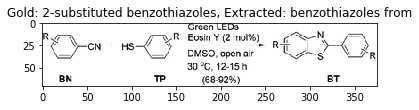

In [193]:
plot_tp_entity(TP[3])

In [195]:
pred1 = true_pred[1]

In [ ]:
print("Organic name: " pred1[0].text)
print("Image title: " pred1[1].description)
print()

In [32]:
def view_pred(pred1):
    fig = plt.figure(figsize=(10,10))
    im = plt.imread(docs_path+pred1[1].url)
    plt.imshow(im, cmap='gray')
    print("Organic name: ", pred1[0].text)
    print("Image title: ", pred1[1].description)
    print("Document: ", pred1[1].document.name)

In [33]:
len(true_pred)

269

Organic name:  benzothiazoles
Image title:  Visible-light-induced synthesis of 2-substituted benzothiazoles from the mixture of thiophenols and nitriles reported in this work.
Document:  Visible light photoredox catalysis_ conversion of a mixture of thiophenols and nitriles into 2-substituted benzothiazoles via consecutive C–S and C–N ... - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C8QO00219C


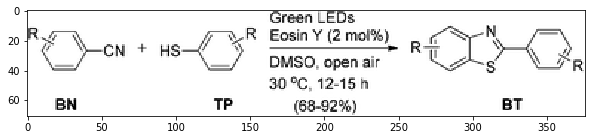

In [34]:
view_pred(true_pred[118])

In [120]:
from fonduer.visualizer import *
vis = Visualizer(pdf_path)

read pdf /Users/liwei/BoxSync/s2016/Dropbox/839_fonduer/tutorials/organic_synthesis_figures/data/pdf/Visible light photoredox catalysis_ conversion of a mixture of thiophenols and nitriles into 2-substituted benzothiazoles via consecutive C–S and C–N ... - Organic Chemistry Frontiers (RSC Publishing) DOI_10.1039_C8QO00219C.pdf


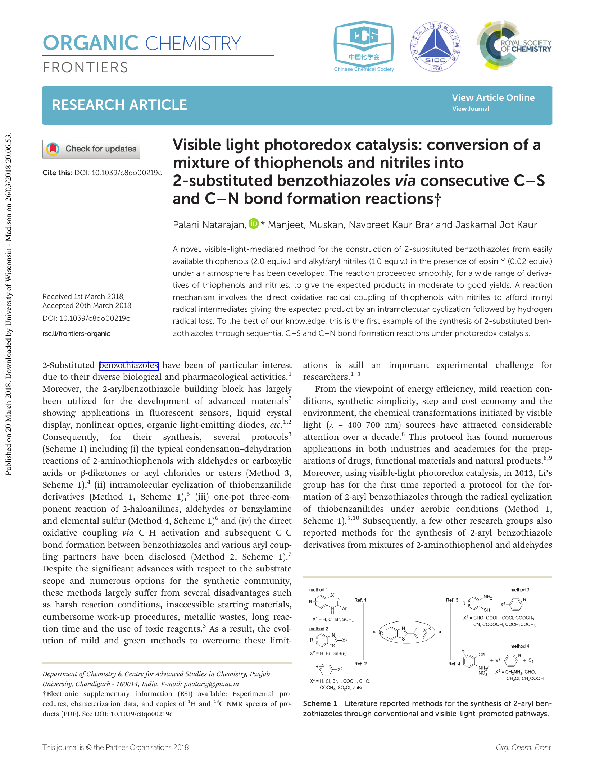

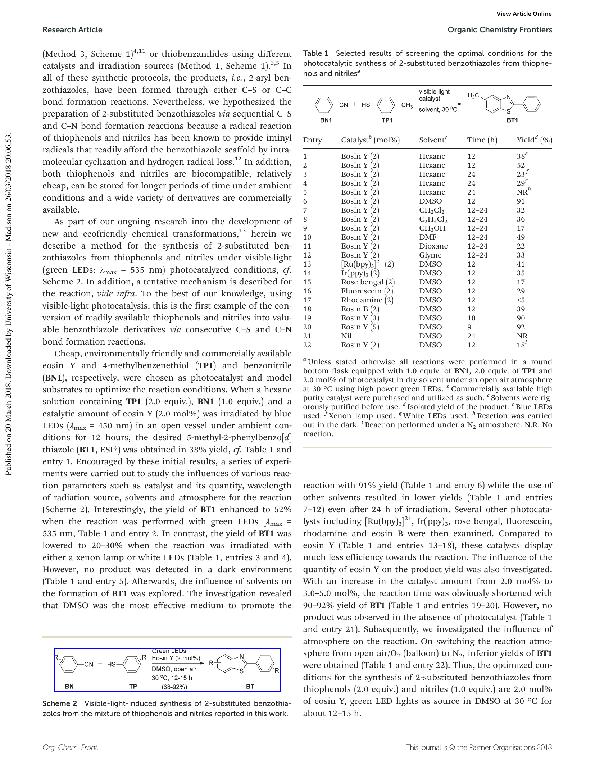

In [127]:
vis.display_image_candidates([true_pred[118]])